In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def sine_gaussian_waveform(t, A, t0, tau, f0, phi0):
    '''
    Parameters:
    t : Array of time values
    A : Amplitude of the waveform
    t0 : Central time of the Gaussian envelope
    tau : Width of the Gaussian envelope
    f0 : Frequency of the sine wave
    phi0 : Phase of the sine wave

    Returns an array of values of the generated sine_gaussian waveform
    '''
    gaussian_envelope = A * np.exp(-((t - t0)**2) / (2 * tau**2))
    sine_wave = np.cos(2 * np.pi * f0 * t + phi0)
    return gaussian_envelope * sine_wave

def generate_waveform_data(num_samples, num_points, A_base, A_variation, t0_base, t0_variation, tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, time_length_base, time_length_variation, signal_present=True):
    '''
Function generates the given sample amount of waveforms with a corresponding label indicating
a signal with noise or if its just pure noise.
    '''
    data = [] 
    labels = []
    
    for _ in range(num_samples):
        # For all samples generate a waveform with slight variations from
        # the base values and input into sine_gaussian_waveform function
        A = A_base + np.random.uniform(-A_variation, A_variation)
        t0 = t0_base + np.random.uniform(-t0_variation, t0_variation)
        f0 = f0_base + np.random.uniform(-f0_variation, f0_variation)
        noise_level = abs(noise_level_base + np.random.uniform(-noise_variation, noise_variation))
        time_length = time_length_base + np.random.uniform(-time_length_variation, time_length_variation)
        
        t = np.linspace(0, time_length, num_points)

        # For present signal combine waveform and noise to create signal with noise
        if signal_present:
            waveform = sine_gaussian_waveform(t, A, t0, tau, f0, phi0)
            noise = np.random.uniform(-noise_level, noise_level, t.shape)
            signal_with_noise = waveform + noise
        # For no signal then just produce noise data 
        else:
            signal_with_noise = np.random.uniform(-noise_level, noise_level, t.shape)

        # Sample some time points and use their amplitudes as features
        sample_indices = np.linspace(0, num_points - 1, 4096, dtype=int)  # Sample points
        sampled_amplitudes = signal_with_noise[sample_indices]
        
        features = sampled_amplitudes
        
        data.append(features)
        labels.append(1 if signal_present else 0)

        
    
    return np.array(data), np.array(labels)



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Parameters for waveform generation
num_samples_per_class = 300  # Number of samples for each class (signal/no signal)
num_points = 4096  # Number of time points that are extracted from each time series sample

# Define base parameters for waveform generation
A_base = 50e-22  # Base amplitude
t0_base = 0.5  # Base central time (seconds)
tau = 0.05  # Width of the Gaussian envelope (seconds)
f0_base = 100  # Base frequency of the sine wave (Hz)
phi0 = 0.0  # Phase of the sine wave (radians)

# Variations in parameters for waveform generation
A_variation = 0  # Variation range for amplitude
t0_variation = 0.3  # Variation range for central time
f0_variation = 10  # Variation range for frequency (Hz)
noise_level_base = 3e-22  # Base noise level
noise_variation = 0  # Variation range for noise level
time_length_base = 1.0  # Base time length (seconds)
time_length_variation = 0.3  # Variation range for time length (seconds)

# Generate data with and without signal
data_with_signal, labels_with_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, signal_present=True
)
data_without_signal, labels_without_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, signal_present=False
)

# Combine data and labels
data = np.concatenate([data_with_signal, data_without_signal])
labels = np.concatenate([labels_with_signal, labels_without_signal])

# Shuffle the data and labels together
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Scale each sample by the base amplitude used for the Gaussian sine wave
data = data / A_base

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=42, stratify=labels)

# Transpose the training and test data
X_train_transposed = X_train.T
X_test_transposed = X_test.T

print(y_train)

# Create labels array where each row is filled with the respective label value for training data
y_train_expanded = np.zeros_like(X_train_transposed)

for i in range(len(y_train)):
    y_train_expanded[i, :] = y_train[i]
    
# Save training data to CSV file
train_df = pd.DataFrame(X_train_transposed)
train_df.to_csv('train.csv', index=False, header=False)

# Save test data to CSV file
test_df = pd.DataFrame(X_test_transposed)
test_df.to_csv('test.csv', index=False, header=False)

# Save training labels to CSV file
labels_train_df = pd.DataFrame(y_train_expanded)
print(labels_train_df.shape)  # Should print (4096, 300)
labels_train_df.to_csv('labels.csv', index=False, header=False)

# Verify the shapes of saved data
print(f'Training data shape: {X_train_transposed.shape}')
print(f'Test data shape: {X_test_transposed.shape}')
print(f'Training labels shape: {y_train_expanded.shape}')


[1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0
 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1
 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1
 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1
 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1
 0 1 0 1]
(4096, 300)
Training data shape: (4096, 300)
Test data shape: (4096, 300)
Training labels shape: (4096, 300)


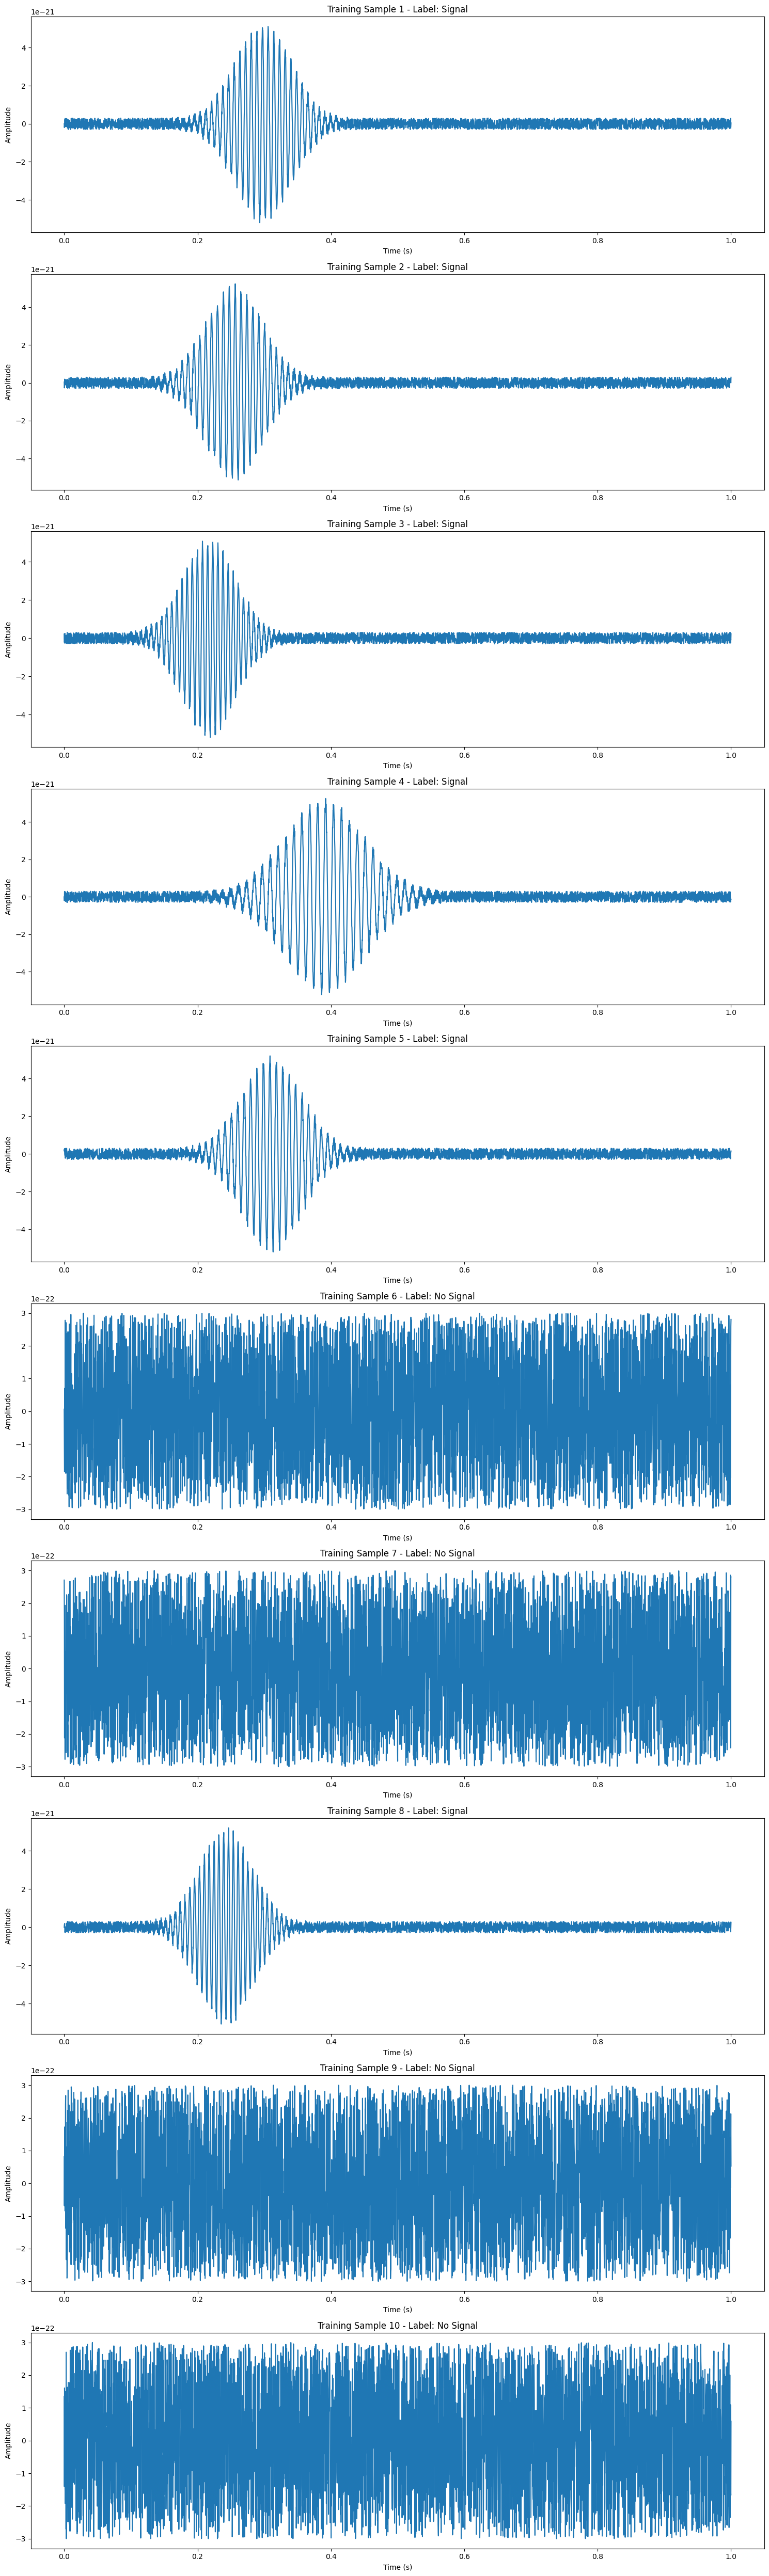

In [3]:
# Parameters for plotting
num_samples_to_plot = 10
num_points = 4096  # Number of time points in each sample
time_indices = np.linspace(0, 1, num_points)  # Time indices corresponding to the data

plt.figure(figsize=(15, 50))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    sample = X_train[i]* A_base  # Scale back to the original amplitude
    plt.plot(time_indices, sample)  # Plot the sampled points
    actual_label = "Signal" if y_train[i] == 1 else "No Signal"
    plt.title(f'Training Sample {i+1} - Label: {actual_label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [7]:
print(labels_train_df[0])

0       1
1       1
2       1
3       1
4       1
       ..
4091    1
4092    1
4093    1
4094    1
4095    1
Name: 0, Length: 4096, dtype: int64


(300,)


ValueError: x and y must have same first dimension, but have shapes (4096,) and (300,)

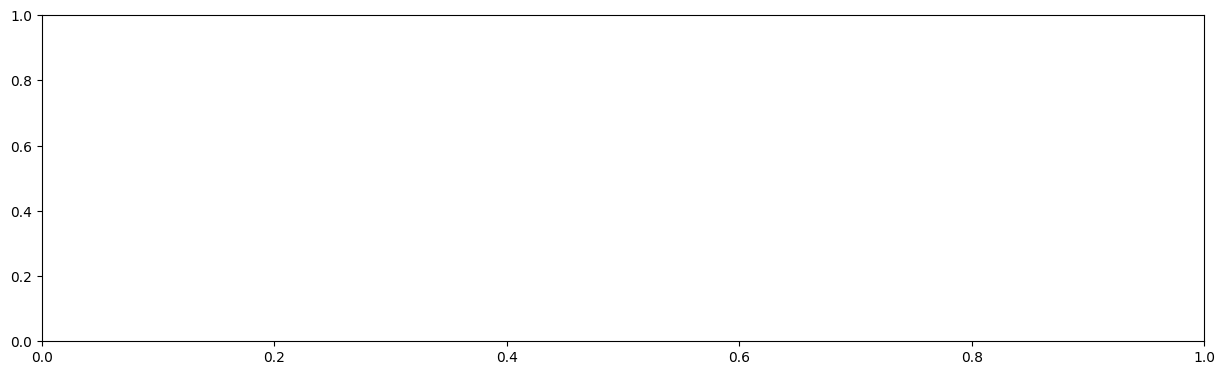

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for plotting
num_samples_to_plot = 10
num_points = 4096  # Number of time points in each sample
time_indices = np.linspace(0, 1, num_points)  # Time indices corresponding to the data

# Load training data from CSV file
train_data = pd.read_csv('train.csv').values[:, 0:]  # Skip first column (index) and remove header if present
print(train_data[0].shape)
# Load labels from CSV file
labels_data = pd.read_csv('labels.csv').values

plt.figure(figsize=(15, 50))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    sample = train_data[i]   # Scale back to the original amplitude
    plt.plot(time_indices, sample)  # Plot the sampled points
    actual_label = "Signal" if labels_data[i] == 1 else "No Signal"
    plt.title(f'Training Sample {i+1} - Label: {actual_label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (4096,) and (300,)

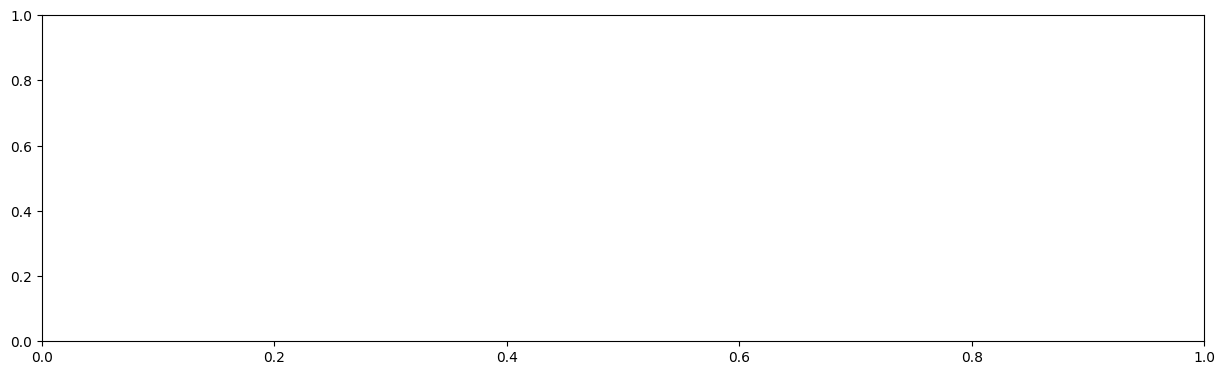

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for plotting
num_samples_to_plot = 10
num_points = 4096  # Number of time points in each sample
time_indices = np.linspace(0, 1, num_points)  # Time indices corresponding to the data

# Load training data from CSV file
train_data = pd.read_csv('train.csv', header=None).values

# Load labels from CSV file
labels_data = pd.read_csv('labels.csv').values

plt.figure(figsize=(15, 50))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    sample = train_data[i]   # Scale back to the original amplitude
    plt.plot(time_indices, sample)  # Plot the sampled points
    actual_label = "Signal" if labels_data[i] == 1 else "No Signal"
    plt.title(f'Training Sample {i+1} - Label: {actual_label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
